In [102]:
import pandas as pd
import numpy as np
from numpy import log
from tqdm import tqdm
from tqdm.notebook import tqdm
from pqdm.threads import pqdm

from collections import Counter
from itertools import chain
from pprint import pprint

from transformers import BertForSequenceClassification, BertTokenizer, TextClassificationPipeline

import iso3166

import missingno as mn

## Roadmap

* [x] Filter only movies with Box Office info
* [x] Format variable Box Office as numeric
* [x] Deflate Box Office to prices of 2022
* [x] Create dummy for `Rated`
* [x] Create dummy `ForeignLanguage` if `Language` is/contains any language other than English
* [x] Set `Country` as list of countries
* [x] Create variable `isCoproduction`
* [x] Transform `Awards` into `win`, `nominated` and `won_Oscar` variables
* [x] Drop columns `imdbRating` and `Metascore`
* [x] Create features with sentiment analysis of plot
* [x] Group genres in Fiction/NonFiction
* [x] Make dummies for genres
* [x] Left-Join Movie-GDELT datasets, m:1. If a movie is a CoProduction of multiple countries, bring the GDELT info of the most extreme country (e.g. in a coProduction between France and Iran, bring GDELT info from Iran). This means $\max{\text{Competitiveness}}$ and $\min{\text{Cooperation}}$ 
* [x] Log-transform BoxOffice, runtimeMinutes, numVotes.

## Methodological decisions:

* Select only movies with non-missing Box Office info
* `isRated = 0` iff movie's `Rating` was one of the following:
    ['Approved','APPROVED','NOT RATED','Not Rated', 'Unrated','None', None, 'Open']
* `ForeignLanguage = 0` iff the film is fully in English. Thus, for example, if the Languages of the film are "English, French", then `ForeignLanguage=1`, not zero, because the film is at least partially in a foreign language.  
* Log-transformed variables:
    * BoxOffice
    * runtimeMinutes
    * numVotes
* Categories grouped together:
    * Genres, in Fiction/NonFiction
* If a movie is a CoProduction of multiple countries, bring the GDELT info of the _worst_ country (e.g. in a coProduction between France and Iran, bring GDELT info from Iran). This means $\max{\text{Competitiveness}}$ and $\min{\text{Cooperation}}$ 
* Not use numVotes in regression due to leakage

## Load dataset

In [103]:
data = pd.read_parquet("../10-data/IMDB_data_final.parquet")
print(data.shape)
data.sample(1)

(56053, 14)


,Title,Year,Rated,Language,Country,Awards,imdbRating,Metascore,BoxOffice,Plot,runtimeMinutes,genres,averageRating,numVotes
tt0113651,Full Throttle,1995,None,Cantonese,Hong Kong,4 wins & 15 nominations,6.5,NaN,None,One of Hong Kong's top motorcycle racers is fo...,114.0,"Action,Drama",6.5,609


## Filter only movies with Box Office info

In [104]:
data = data[~data['BoxOffice'].isna()]
data.sample(1)

,Title,Year,Rated,Language,Country,Awards,imdbRating,Metascore,BoxOffice,Plot,runtimeMinutes,genres,averageRating,numVotes
tt1663321,Chicken with Plums,2011,PG-13,"French, English","France, Germany, Belgium",3 wins & 8 nominations,7.0,69.0,"$253,874","Since his beloved violin was broken, Nasser Al...",93.0,"Comedy,Drama",7.0,9879


## Format variable Box Office as numeric

In [105]:
data['BoxOffice'] = data['BoxOffice'].replace('[\$,]', '', regex=True).astype('float')
data.BoxOffice.sample(5)

tt0092130     227510.0
tt0085859    5895761.0
tt0353818      60712.0
tt4358230       2457.0
tt7802246      10128.0
Name: BoxOffice, dtype: float64

## Deflate Box Office

In [106]:
#Load CPI data
cpi = pd.read_excel('../10-data/CPI_data.xlsx', index_col='Year', usecols=['Year','Annual'])
cpi = cpi[(cpi.index >=1980) & (cpi.index <=2022)]

#Get CPI of year of reference (YoR)
YoR = 2022
CPI_YoR = cpi[cpi.index==YoR].values[0][0]

#Calculate deflation indexes
cpi['_deflation_index'] = CPI_YoR / cpi

#keep only deflation index column
cpi = cpi['_deflation_index']

#cpi

In [107]:
data = pd.merge(data, cpi, on='Year', how='left')
data[['Title','Year','_deflation_index']].sample(10)
data['BoxOffice'] = data.BoxOffice * data._deflation_index
data = data.drop(columns=['_deflation_index'])

In [108]:
data[['Title','Year','BoxOffice']].sample(5)

,Title,Year,BoxOffice
2342,Pieta,2012,2.814456e+04
3435,Hellbound?,2012,2.917321e+04
1492,Attack the Block,2011,1.332494e+06
584,No Man's Land,2020,1.574265e+05
1285,Painted Skin: The Resurrection,2012,6.427489e+04


## Create dummy for `Rated`

In [109]:
data['_Rated'] = data['Rated'].replace(['Approved','APPROVED',
                                        'NOT RATED','Not Rated', 'Unrated',
                                        'None', None,
                                        'Open'],
                                       np.nan)

data['isRated'] = ~data['_Rated'].isna()

In [110]:
#data[['Rated','_Rated','isRated']].sample(10, random_state=123)

In [111]:
#pd.crosstab(data.Rated, data.isRated)

In [112]:
if all(col in data.columns for col in ['Rated','_Rated']):
    data.drop(columns=['Rated','_Rated'], inplace = True)

## Create dummy `ForeignLanguage` if `Language` is/contains any language other than English

In [113]:
data['ForeignLanguage'] = data['Language'] == 'English'

if 'Language' in data.columns:
    data.drop(columns=['Language'], inplace = True)

## Set `Country` as list of countries

In [114]:
data['Country'] = data.Country.str.split(',')

## Create variable `isCoproduction`


In [115]:
data['isCoproduction'] = data.Country.apply(lambda x: len(x) > 1)

## Transform `Awards` into `win` and `nominated` variables

In [116]:
data['win_award'] = data.Awards.str.contains(r'(?i)\bwin(?:s|\b)').fillna(False)
data['nominated_award'] = data.Awards.str.contains(r'(?i)\b(?:nominated|nomination)s?\b').fillna(False)
data['won_Oscar'] = data.Awards.str.contains(r'(?i)won (\d+) oscar(s?)').fillna(False)

C:\Users\felbu\AppData\Local\Temp\ipykernel_18976\3073514404.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data['won_Oscar'] = data.Awards.str.contains(r'(?i)won (\d+) oscar(s?)').fillna(False)


In [117]:
data[['Awards','win_award','nominated_award','won_Oscar']].sample(10, random_state=123)

,Awards,win_award,nominated_award,won_Oscar
2328,4 wins & 11 nominations,True,True,False
2585,2 wins & 2 nominations,True,True,False
2689,25 wins & 14 nominations,True,True,False
4229,5 wins & 14 nominations,True,True,False
3222,5 wins & 3 nominations,True,True,False
2154,15 wins & 9 nominations,True,True,False
2024,10 wins & 16 nominations,True,True,False
761,None,False,False,False
2942,30 wins & 38 nominations,True,True,False
3450,5 wins & 7 nominations,True,True,False


In [118]:
if 'Awards' in data.columns:
    print(data.shape)
    data.drop(columns=['Awards'], inplace = True)
    print(data.shape)

(4822, 18)
(4822, 17)


## Drop columns `imdbRating` and `Metascore`

In [119]:
print(data.shape)
if all(col in data.columns for col in ['imdbRating','Metascore']):
    data.drop(columns=['imdbRating','Metascore'], inplace=True)
print(data.shape)

(4822, 17)
(4822, 15)


## Create feature with sentiment analysis of plot

In [120]:
model_path = "JiaqiLee/imdb-finetuned-bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

In [121]:
def pipeline_(x):
    if x == None:
        return(np.nan, np.nan)
    else:
        sentiment = pipeline(x)[0]
        label, score = sentiment['label'], sentiment['score']
        return(label, score)

In [122]:
#Takes looooong time!
sentiment_analysis = list(pqdm(data['Plot'], pipeline_, n_jobs=4))

QUEUEING TASKS | :   0%|          | 0/4822 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4822 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4822 [00:00<?, ?it/s]

In [123]:
#Only if previous cell has run
data['plot_sentiment_polarity'] = [t[0] for t in sentiment_analysis]
data['plot_sentiment_score'] = [t[1] for t in sentiment_analysis]

In [124]:
data.plot_sentiment_polarity.value_counts(normalize=True)

positive    0.753061
negative    0.246939
Name: plot_sentiment_polarity, dtype: float64

<Axes: >

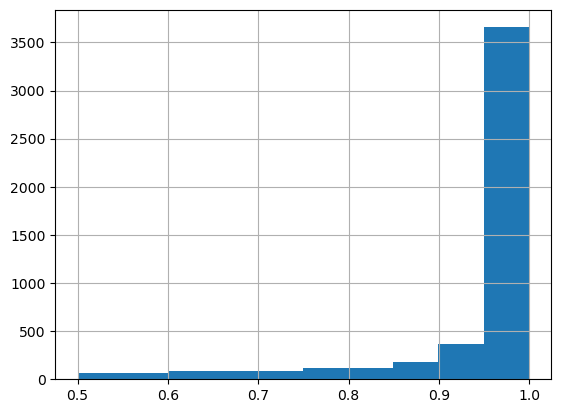

In [125]:
data.plot_sentiment_score.hist()

In [126]:
# Convert plot_sentiment_polarity to dummy
data['isPositivePlot'] = data.plot_sentiment_polarity.replace({'positive':1,'negative':0})

In [127]:
if 'Plot' in data.columns:
    print(data.shape)
    data.drop(columns=['Plot'], inplace = True)
    print(data.shape)

(4822, 18)
(4822, 17)


## Make dummies for Genres

In [128]:
all_genres = []
for movie_genres in tuple(data.genres.str.split(',')):
    all_genres.extend(movie_genres)

#pprint(Counter(all_genres))

all_genres = set(all_genres)
print(f"Number of genre types: {len(all_genres)}")

Number of genre types: 22


In [129]:
nonfiction = {'Documentary','News','Sport'}
fiction = all_genres - nonfiction

In [130]:
for i, (movie_id, movie) in tqdm(enumerate(data.iterrows())):
    try:
        genres = movie.genres.split(',')
        isFiction = max(list(map(lambda x: x in fiction, genres)))
        data.loc[movie_id,'isFiction'] = isFiction #If one genre is fiction, the movie is fiction
    except:
        print('Error in ', i, movie_id)

0it [00:00, ?it/s]

## Merge with GDELT

In [131]:
gdelt = pd.read_csv('../10-data/gdelt.csv')
print(gdelt.shape)
print(gdelt.head())

(8242, 4)
   Year Country  Competitiveness  Cooperativeness
0  1980     AFG         7.464624         7.793504
1  1980     AFR         5.677438         6.400424
2  1980     AGO         4.574711         4.647271
3  1980     ALB         2.602690         3.295837
4  1980     ARE         0.587787         4.275276


In [132]:
name_to_alpha3 = {
    'Afghanistan': 'AFG',
    'Albania': 'ALB',
    'Algeria': 'DZA',
    'Angola': 'AGO',
    'Argentina': 'ARG',
    'Armenia': 'ARM',
    'Australia': 'AUS',
    'Austria': 'AUT',
    'Azerbaijan': 'AZE',
    'Bangladesh': 'BGD',
    'Belarus': 'BLR',
    'Belgium': 'BEL',
    'Bhutan': 'BTN',
    'Bolivia': 'BOL',
    'Bosnia and Herzegovina': 'BIH',
    'Botswana': 'BWA',
    'Brazil': 'BRA',
    'Bulgaria': 'BGR',
    'Burkina Faso': 'BFA',
    'Cambodia': 'KHM',
    'Cameroon': 'CMR',
    'Canada': 'CAN',
    'Chad': 'TCD',
    'Chile': 'CHL',
    'China': 'CHN',
    'Colombia': 'COL',
    'Congo': 'COG',
    'Croatia': 'HRV',
    'Cuba': 'CUB',
    'Cyprus': 'CYP',
    'Czech Republic': 'CZE',
    'Denmark': 'DNK',
    'Dominican Republic': 'DOM',
    'Egypt': 'EGY',
    'Estonia': 'EST',
    'Federal Republic of Yugoslavia': 'YUG',  # Note: Yugoslavia isn't assigned an official 3-letter code post-disintegration
    'Finland': 'FIN',
    'France': 'FRA',
    'Georgia': 'GEO',
    'Germany': 'DEU',
    'Ghana': 'GHA',
    'Greece': 'GRC',
    'Greenland': 'GRL',
    'Guatemala': 'GTM',
    'Haiti': 'HTI',
    'Hong Kong': 'HKG',
    'Hungary': 'HUN',
    'Iceland': 'ISL',
    'India': 'IND',
    'Indonesia': 'IDN',
    'Iran': 'IRN',
    'Iraq': 'IRQ',
    'Ireland': 'IRL',
    'Isle of Man': 'IMN',
    'Israel': 'ISR',
    'Italy': 'ITA',
    'Jamaica': 'JAM',
    'Japan': 'JPN',
    'Jordan': 'JOR',
    'Kazakhstan': 'KAZ',
    'Kenya': 'KEN',
    'Kosovo': 'UNK',  # Note: Kosovo has a provisional ISO 3166-1 alpha-3 code 'UNK'
    'Laos': 'LAO',
    'Latvia': 'LVA',
    'Lebanon': 'LBN',
    'Liberia': 'LBR',
    'Liechtenstein': 'LIE',
    'Lithuania': 'LTU',
    'Luxembourg': 'LUX',
    'Macao': 'MAC',
    'Malaysia': 'MYS',
    'Mali': 'MLI',
    'Malta': 'MLT',
    'Mauritania': 'MRT',
    'Mexico': 'MEX',
    'Monaco': 'MCO',
    'Mongolia': 'MNG',
    'Morocco': 'MAR',
    'Myanmar': 'MMR',
    'Nepal': 'NPL',
    'Netherlands': 'NLD',
    'New Zealand': 'NZL',
    'Nigeria': 'NGA',
    'North Korea': 'PRK',
    'North Macedonia': 'MKD',
    'Norway': 'NOR',
    'Occupied Palestinian Territory': 'PSE',
    'Pakistan': 'PAK',
    'Panama': 'PAN',
    'Papua New Guinea': 'PNG',
    'Paraguay': 'PRY',
    'Peru': 'PER',
    'Philippines': 'PHL',
    'Poland': 'POL',
    'Portugal': 'PRT',
    'Puerto Rico': 'PRI',
    'Qatar': 'QAT',
    'Reunion': 'REU',
    'Romania': 'ROU',
    'Russia': 'RUS',
    'Rwanda': 'RWA',
    'Saudi Arabia': 'SAU',
    'Senegal': 'SEN',
    'Serbia': 'SRB',
    'Serbia and Montenegro': 'SCG',  # Note: Serbia and Montenegro is part of the former Yugoslavia
    'Sierra Leone': 'SLE',
    'Singapore': 'SGP',
    'Slovakia': 'SVK',
    'Slovenia': 'SVN',
    'South Africa': 'ZAF',
    'South Korea': 'KOR',
    'Soviet Union': 'SUN',  # Note: Soviet Union is no longer existent; 'SUN' is an obsolete code
    'Spain': 'ESP',
    'Sweden': 'SWE',
    'Switzerland': 'CHE',
    'Syria': 'SYR',
    'Taiwan': 'TWN',
    'Tajikistan': 'TJK',
    'Tanzania': 'TZA',
    'Thailand': 'THA',
    'The Democratic Republic of Congo': 'COD',
    'Tunisia': 'TUN',
    'Turkey': 'TUR',
    'Ukraine': 'UKR',
    'United Arab Emirates': 'ARE',
    'United Kingdom': 'GBR',
    'Uruguay': 'URY',
    'Vanuatu': 'VUT',
    'Vatican': 'VAT',
    'Venezuela': 'VEN',
    'Vietnam': 'VNM',
    'West Germany': 'DEU',  # Assuming West Germany refers to historical Germany
    'Yugoslavia': 'YUG',  # Assuming Yugoslavia refers to the former Yugoslavia
    'Zambia': 'ZMB',
    'Zimbabwe': 'ZWE'
}

In [133]:
#para cada filme...
for i, (movie_id, movie) in tqdm(enumerate(data.iterrows())):     
    year = movie.Year
    comp_list, coop_list = [], []
    
    #para cada pais produtor do filme...
    for j, country in enumerate(movie.Country):
        country = country.lstrip()
        
        #veja o codigo 3 letras dele...
        alpha3 = name_to_alpha3[country]
        
        # ... e usa isso para buscar no GDELT dados de competitividade e cooperatividade
        gdelt_ = gdelt.loc[(gdelt.Year == year) & (gdelt.Country == alpha3),['Competitiveness','Cooperativeness']]
        try:
            #pega os dados de competitividade e cooperação e salva nas listas
            comp, coop = gdelt_.values[0][0], gdelt_.values[0][1]
            comp_list.append(comp)
            coop_list.append(coop)
        except:
            #print('Error in movie ', movie_id, ' country ', country)
            pass
    
    try:
        data.loc[movie_id, 'Competitiveness'] = max(comp_list)
        data.loc[movie_id, 'Cooperativeness'] = min(coop_list)
    except:
        pass

0it [00:00, ?it/s]

In [134]:
#data

In [135]:
pprint(data.Competitiveness.isna().value_counts())
pprint(data.Cooperativeness.isna().value_counts())

False    4772
True       50
Name: Competitiveness, dtype: int64
False    4772
True       50
Name: Cooperativeness, dtype: int64


<Axes: >

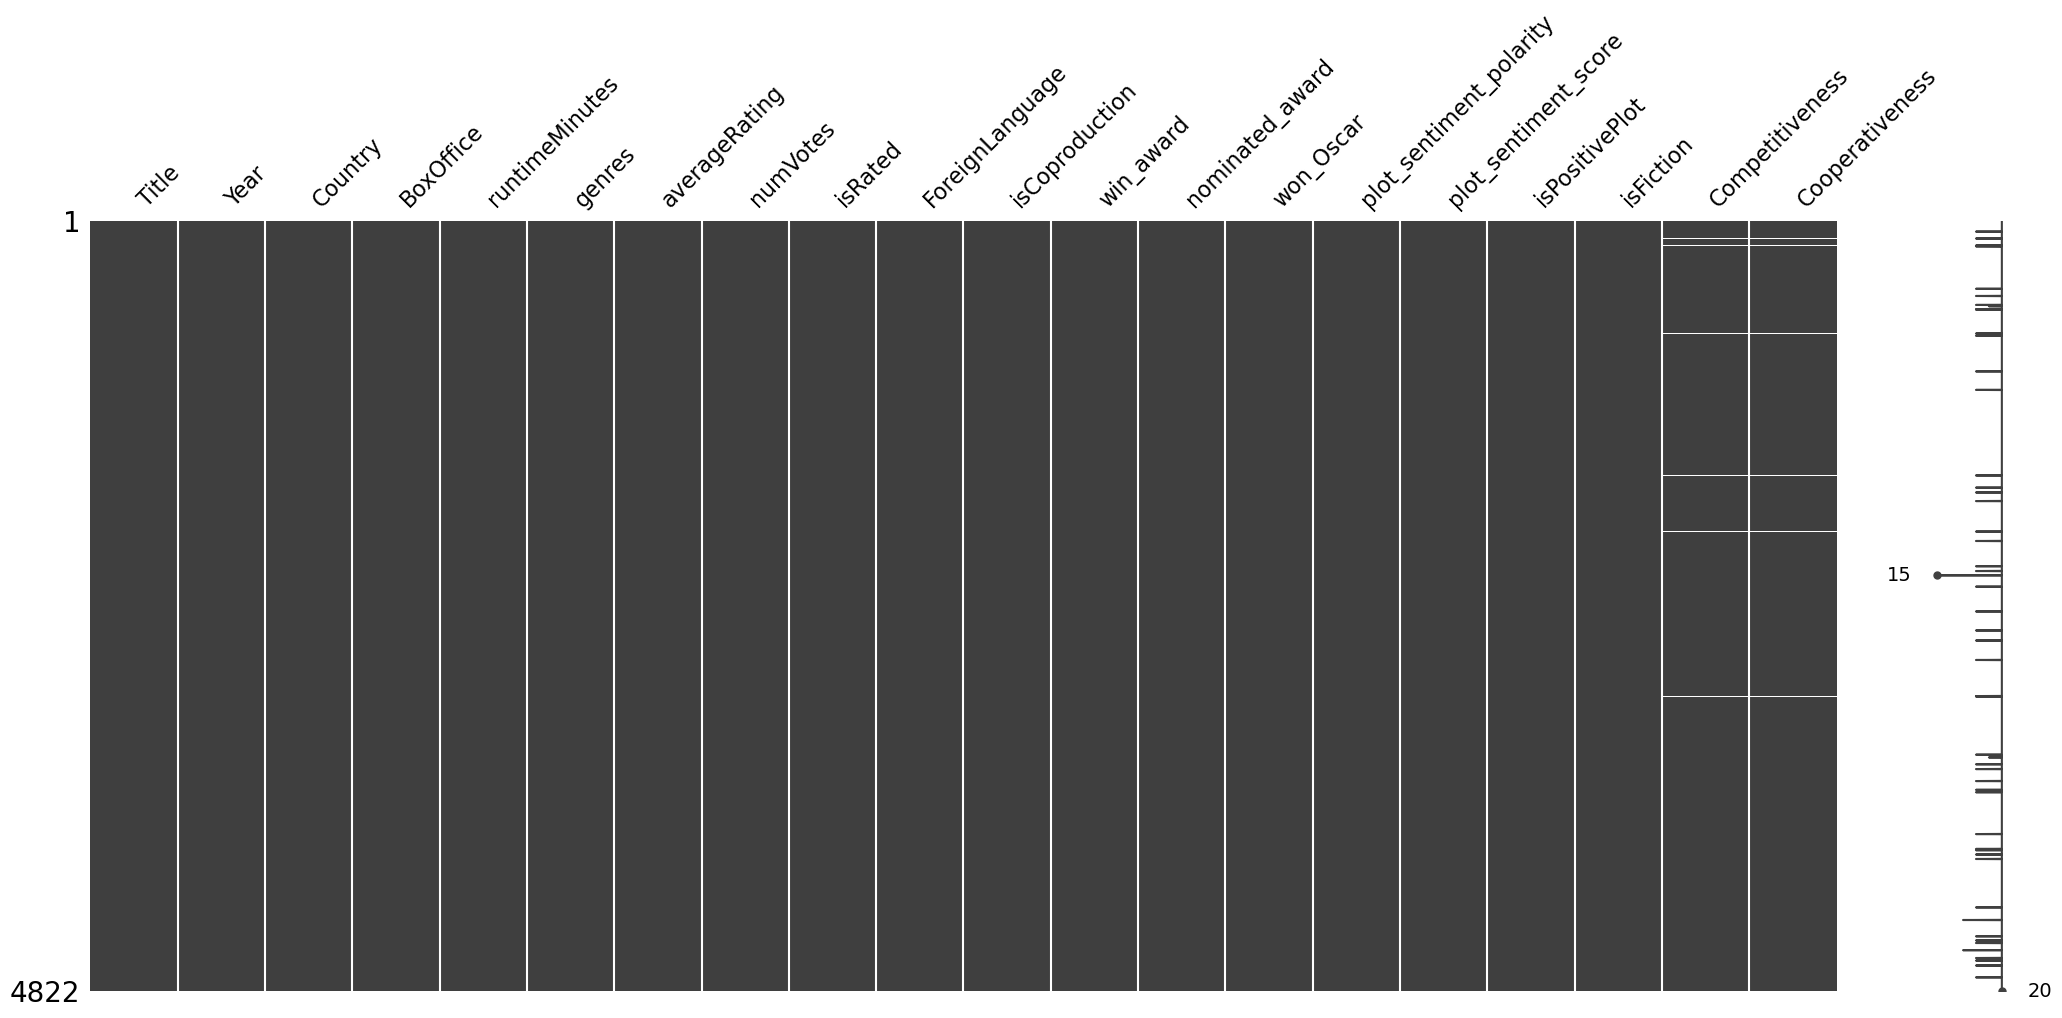

In [136]:
mn.matrix(data)

<Axes: >

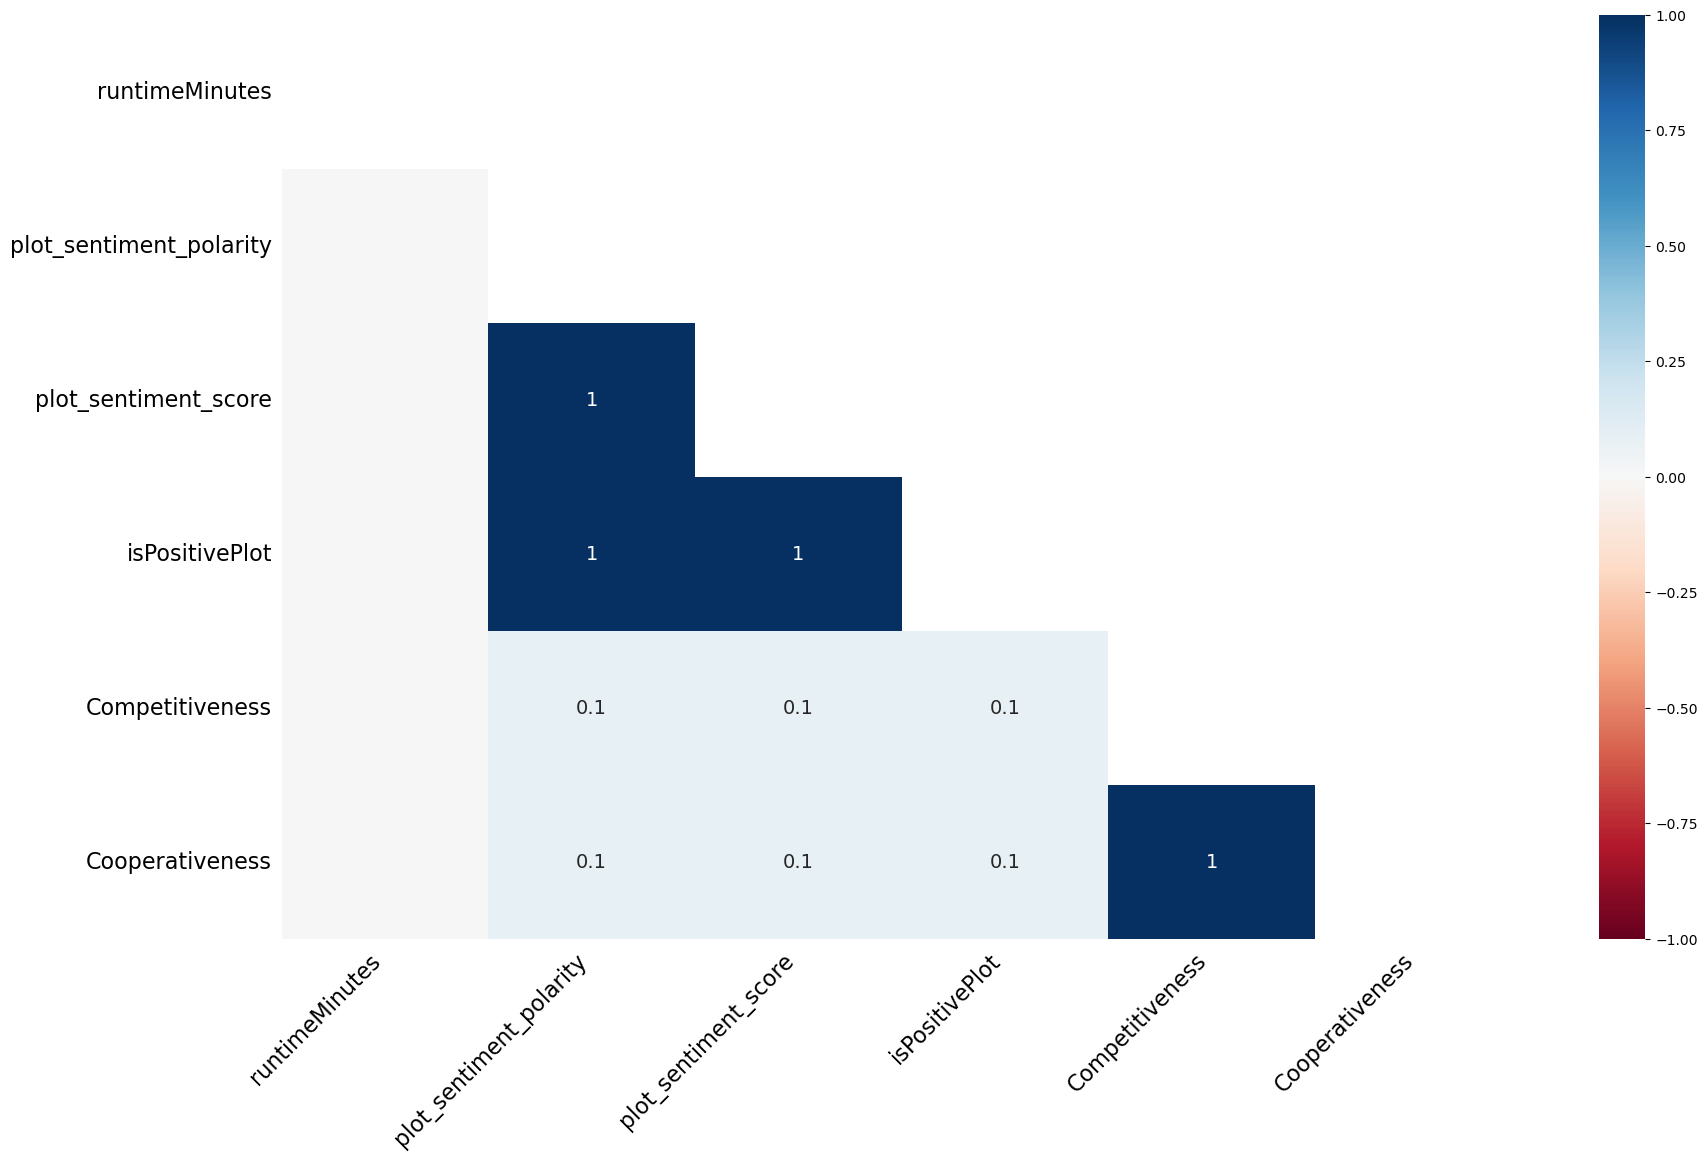

In [137]:
mn.heatmap(data)

In [138]:
data[["Competitiveness","Cooperativeness"]].corr()

,Competitiveness,Cooperativeness
Competitiveness,1.000000,0.732503
Cooperativeness,0.732503,1.000000


<Axes: xlabel='Competitiveness', ylabel='Cooperativeness'>

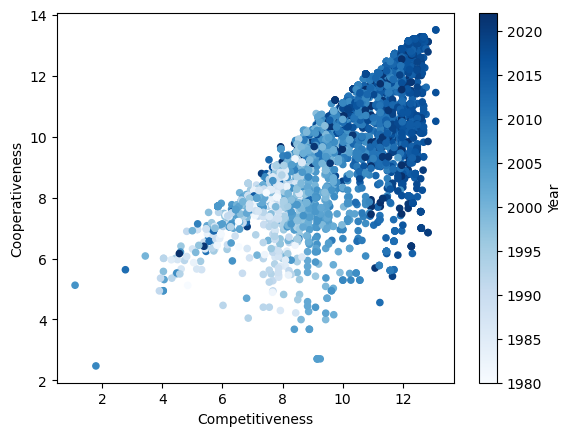

In [139]:
data.plot(x="Competitiveness", 
          y="Cooperativeness", 
          c='Year', 
          cmap='Blues',
          kind='scatter')

<Axes: xlabel='Year'>

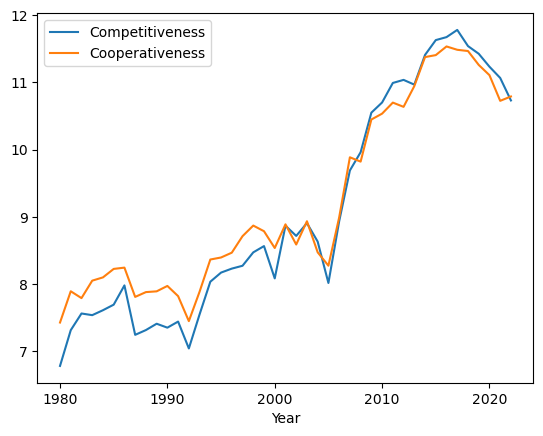

In [140]:
data[["Year","Competitiveness","Cooperativeness"]].groupby('Year').mean().plot()

## Log-Transform

In [141]:
data['logBoxOffice'] = log(data['BoxOffice'])
data['logRunTime'] = log(data['runtimeMinutes'])
data['logNumVotes'] = log(data['numVotes'])

## Delete missing

In [142]:
print(data.shape)
data = data.dropna()
print(data.shape)

(4822, 23)
(4768, 23)


## Save dataset

In [143]:
#data.dtypes

In [144]:
data.to_parquet('../10-data/data_final.parquet')